# ***Random Forest***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import os
import time
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_sample_weight

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import plotly.graph_objects as go
import lime.lime_tabular

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
model_filename = "../Models/best_rf_model.pkl"
study_filename = "../Study/optuna_study_RF_nested.pkl"
metrics_filename = "../Models/best_rf_metrics.pkl"
fold_metrics_filename = "./Metrics/rf_folds_summary.csv"

In [4]:
# MODEL PIPELINE BUILDER
def build_pipeline(params: dict, numeric_features: list, categorical_features: list):
    preprocessor = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Sin Dato")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features)
    ], verbose_feature_names_out=False)

    model = RandomForestClassifier(**params, random_state=SEED, class_weight="balanced")
    return Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [5]:
# OPTUNA INNER CV OPTIMIZATION
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.01, log=True)
        }

        pipeline = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            pipeline.fit(X_t, y_t)
            y_pred = pipeline.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [6]:
# NESTED CV LOOP
def nested_cv(X, y, numeric_features, categorical_features):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_model, best_metrics = None, {}
    best_f1 = -np.inf
    optuna_studies = []

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total= outer_cv.get_n_splits(),
        desc= "Training Folds"):

        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        X_tr, X_val, y_tr, y_val = train_test_split(X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        optuna_time = time.time() - start_time
        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": optuna_time
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }


    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations


In [7]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTEO_PRODUCTOS',
                                                   'CAPITAL', 'EDAD',
                                                   'DiasUltimaGestion',
                                                   'DiasMejorGestion',
                                                   'HabitoPago11',
                                                   'Habi...
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=0.00012048986959164597,
                                        class_weight='balanced', max_depth=10,
                                        min_samples_leaf=4, min_samples_split=4,
                                        n_estimators=101, random_state=42))])

In [9]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3426
           1       0.69      0.75      0.72      1034
           2       0.67      0.73      0.70       625

    accuracy                           0.85      5085
   macro avg       0.77      0.79      0.78      5085
weighted avg       0.86      0.85      0.85      5085



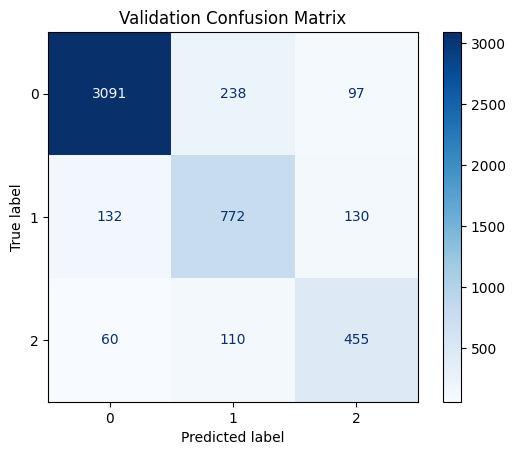

In [10]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [11]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4282
           1       0.68      0.75      0.71      1292
           2       0.70      0.71      0.70       781

    accuracy                           0.85      6355
   macro avg       0.77      0.79      0.78      6355
weighted avg       0.86      0.85      0.85      6355



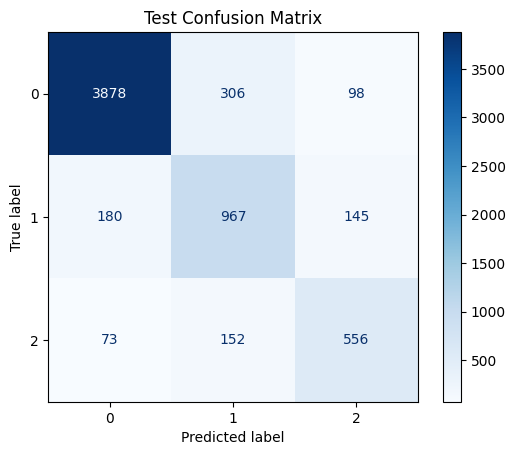

In [12]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

--- Explanation for class 0 ---


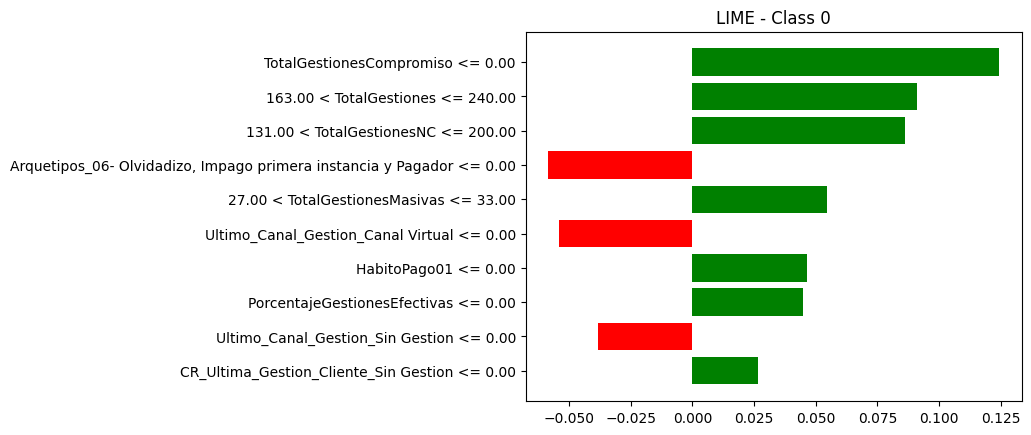

--- Explanation for class 1 ---


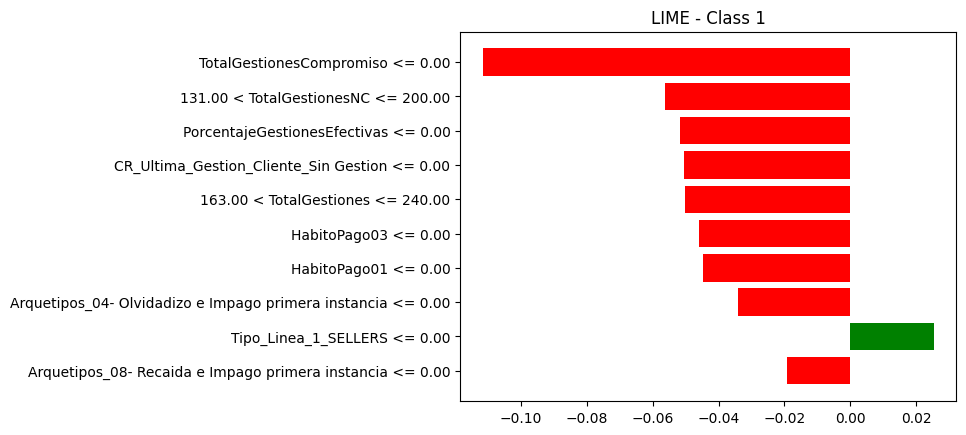

--- Explanation for class 2 ---


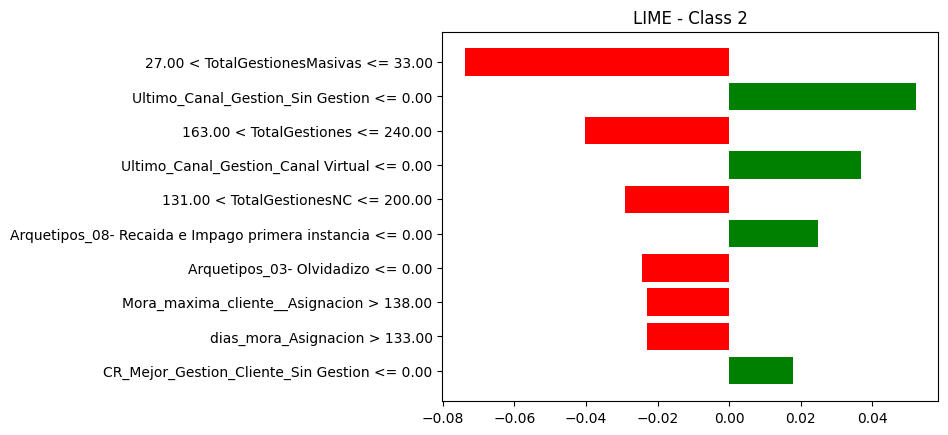

In [13]:
# Get LIME explainer and transformed data
explainer, X_transformed = me.get_lime_explainer(model, metrics['X_train_fold'], metrics['y_train_fold'])

clf = model.named_steps['classifier']
predict_fn = lambda x: clf.predict_proba(x)
instance = X_transformed[10]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp.show_in_notebook(show_table=True)

# Plot per-class explanations
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()



In [14]:
visualizations['optimization_history']

In [15]:
visualizations['parallel_coordinate']

In [16]:
visualizations['f1_score_evolution']

In [17]:
visualizations['param_importances']

In [18]:
# Feature Importance Plot
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

fig = px.bar(importance_df,
             x='Feature',
             y='Importance',
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',
             color_continuous_scale='Viridis',
             text='Importance')
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [19]:
reporte.save(metrics, model_name="RF")


Report for model 'RF' saved:
   → CSV: ./Metrics/Metrics_RF.csv
   → JSON: ./Metrics/Metrics_RF.json


In [20]:
df = reporte.load()


Loaded 8 report(s)


In [21]:
df.query("Model == 'RF' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
6,RF,val,0,0.942,0.902,0.921
7,RF,val,1,0.689,0.747,0.717
8,RF,val,2,0.667,0.728,0.696
9,RF,val,macro avg,0.766,0.792,0.778
10,RF,val,weighted avg,0.857,0.849,0.852


In [22]:
df.query("Model == 'RF' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
12,RF,test,0,0.939,0.906,0.922
13,RF,test,1,0.679,0.748,0.712
14,RF,test,2,0.696,0.712,0.704
15,RF,test,macro avg,0.771,0.789,0.779
16,RF,test,weighted avg,0.856,0.85,0.852


In [ ]:
df.query("Model == 'RF' and auc != '-' and Type != 'train'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
5,RF,train,0.883,0.409,0.969
11,RF,val,0.849,0.463,0.949
17,RF,test,0.85,0.457,0.952


In [24]:
df.query("Model == 'RF' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
11,RF,val,0.849,0.463,0.949


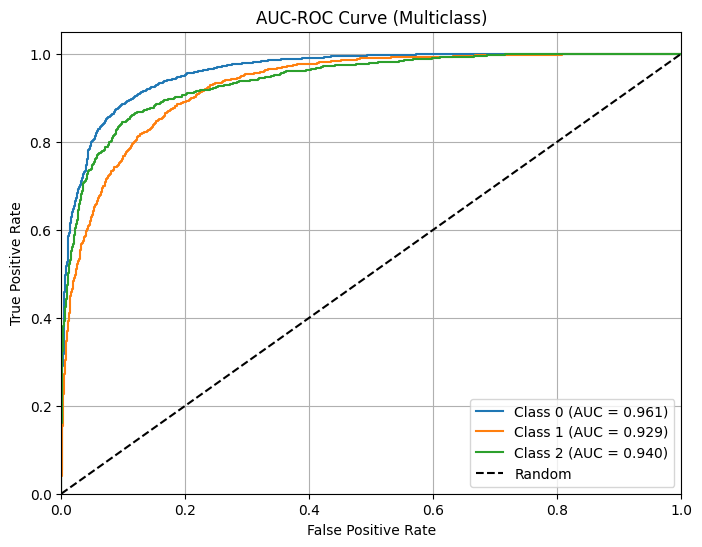

In [25]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [26]:
model.named_steps["classifier"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.00012048986959164597,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 101,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}